# Topic modeling on abstracts

## 1. Preprocessing

In [1]:
import pandas as pd
import os 
import numpy as np
import re
import random

In [2]:
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [ ]:
#!pip install gensim

In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### 1.1 Load the data 

In [4]:
#abstracts = pd.read_csv("abstracts.csv")
abstracts = pd.read_csv("abstracts_eng.csv")

In [5]:
abstracts.head()

,abstract,id
0,The goal of this note is to introduce new clas...,188444.0
1,We will review a Lemma published by Ran Raz in...,188623.0
2,China’s growing influence in Europe has the po...,346708.0
3,Nowhere is China's Belt and Road Initiative (B...,346709.0
4,Passenger transit modes typical of the urban s...,187461.0


In [6]:
abs_list = list(abstracts['abstract'])

In [7]:
len(abs_list)

20494

**21421** abstracts in total  
**20494** abstracts in english

### 1.2 Step 1 
- tokenization 
- punctuation removal 
- lowercasing

In [8]:
tokenised = []
count = 0
for abstract in abs_list:
    raw = abstract
    tokens = gensim.utils.simple_preprocess(str(raw), deacc=True)
    tokenised.append(tokens)
    count += len(tokens)
print(str(count)+" tokens created")

3855522 tokens created


In [9]:
c = []
for doc in tokenised: 
    c+=doc
len(set(c))

71429

So we have **83831** / **71429** (de/en) unique words in the beginning

### 1.3 Step 2 
- removing stopwords 
- (removing other words based on different strategies - like word length thresholding) 

In [10]:
stop_words = stopwords.words('english')
cleaned = [[word for word in doc if word not in stop_words] for doc in tokenised]

In [11]:
# Consider extending the stopwords ...
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
# Consider removing words with less than [x] characters 

In [13]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

71293

Now after stopwords removal we have **83695** / **71293** terms (136 less)

### 1.4 Step 3 
- stemming 
- lemmatizing 

In [14]:
#nltk.download('wordnet')

In [15]:
word_stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
lemmatized = [[lemmatiser.lemmatize(word_stemmer.stem(word)) for word in doc] for doc in cleaned]

In [16]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

71293

And after stemming and lemmatization we have **61182** / **50948** terms (22,513 less)

# Daniel: slightly different approach


What I wanted to do is a bigram model where all words are grouped in two as shown below. I wanted to vectorise this and feed it into LDA to get more specific topics. This seems overcomplicated and potentially wrong the more I do it so I do not think it works.

In [29]:
print(lemmatized[0])

['goal', 'note', 'introduc', 'new', 'class', 'oper', 'ideal', 'moreov', 'new', 'way', 'construct', 'class', 'applic', 'oper', 'asymptot', 'structur', 'recent', 'introduc', 'maurey', 'milman', 'tomczak', 'jaegermann', 'op', 'th', 'adv', 'appl']


In [19]:
#See what an abstract looks like after preprocessing
abstract_clean = []
for i in range(len(lemmatized)):
    b=(' '.join(word for word in lemmatized[i]))
    abstract_clean.append(b)
print(abstract_clean[23])

last two decad electr distribut sector wit wave regulatori reform aim improv effici incent regul regul scheme use benchmark name measur compani effici reward accordingli reliabl effici estim crucial effect implement incent mechan main problem face regul choic among sever legitim benchmark model usual produc differ result brief overview benchmark methodolog paper summar method use regul practic sever oecd countri benchmark practic rel widespread repeat observ similar compani time name panel data allow better understand unobserv firm specif factor disentangl effici estim focus parametr cost frontier model paper present two altern approach could use improv reliabl benchmark method base recent empir evid draw recommend regulatori practic power distribut network


In [86]:
bigram = []
for tokens in range(0,len(lemmatized)):
    bg = nltk.bigrams(lemmatized[tokens])
    bigram.append(bg)

In [87]:
bigrm =[]
for bigs in range(0,len(bigram)):
    separated = list(map(' '.join, bigram[bigs]))
    bigrm.append(separated)

In [88]:
bigrm[2]

['china grow',
 'grow influenc',
 'influenc europ',
 'europ potenti',
 'potenti creat',
 'creat new',
 'new geo',
 'geo econom',
 'econom divid',
 'divid purchas',
 'purchas critic',
 'critic infrastructur',
 'infrastructur success',
 'success promot',
 'promot nation',
 'nation high',
 'high tech',
 'tech giant',
 'giant hold',
 'hold long',
 'long term',
 'term secur',
 'secur implic',
 'implic europ',
 'europ world',
 'world order',
 'order alway',
 'alway europ',
 'europ first',
 'first vex',
 'vex challeng',
 'challeng find',
 'find uniti',
 'uniti promot',
 'promot coher',
 'coher across',
 'across contin',
 'contin eu',
 'eu implement',
 'implement activist',
 'activist industri',
 'industri polici',
 'polici boost',
 'boost high',
 'high tech',
 'tech competit',
 'competit advantag',
 'advantag take',
 'take necessari',
 'necessari measur',
 'measur prevent',
 'prevent grow',
 'grow econom',
 'econom depend',
 'depend china',
 'china china',
 'china wachsend',
 'wachsend einflu

In [95]:
bigram = gensim.models.Phrases(lemmatized, min_count=3, threshold=50) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigramed = [bigram_mod[doc] for doc in lemmatized]

In [97]:
bigramed[3]

['nowher',
 'china',
 'belt_road',
 'initi_bri',
 'evid',
 'eurasia',
 'span',
 'central_asia',
 'eastern_europ',
 'china',
 'transform',
 'space',
 'physic',
 'infrastructur',
 'also',
 'polit',
 'societ',
 'engag',
 'china',
 'econom',
 'clout',
 'bri',
 'land',
 'base',
 'compon',
 'belt',
 'alreadi',
 'yield',
 'consider',
 'leverag',
 'may',
 'allow',
 'beij',
 'signific',
 'leeway',
 'shape',
 'region',
 'futur',
 'ass',
 'china',
 'conduct',
 'ground',
 'help',
 'reveal',
 'true',
 'intent',
 'effect',
 'transform',
 'wrought',
 'nirgendwo',
 'ist',
 'china',
 'belt_road',
 'initi_bri',
 'al',
 'eurasien',
 'da',
 'sich',
 'von',
 'zentralasien',
 'bi',
 'nach',
 'osteuropa',
 'erstreckt',
 'china',
 'verandert',
 'diesen',
 'raum',
 'durch',
 'physisch',
 'infrastruktur',
 'aber_auch',
 'durch',
 'politisch',
 'und',
 'engag',
 'china',
 'gewicht',
 'und_die',
 'landgestutzt',
 'komponent',
 'der',
 'bri',
 'der',
 'belt',
 'haben',
 'bereit',
 'ein_betrachtlich',
 'hebelwirkun

In [98]:
dictionary = corpora.Dictionary(bigramed)
corpus = [dictionary.doc2bow(text) for text in bigramed]

In [99]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim

In [104]:
# Printing the Keywords in topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(25,
  '0.122*"matter" + 0.079*"surprisingli" + 0.062*"ci" + 0.037*"prime" + '
  '0.035*"appar" + 0.000*"su_su" + 0.000*"stormvex" + 0.000*"spl" + '
  '0.000*"iwc" + 0.000*"ifrac"'),
 (12,
  '0.276*"trade" + 0.091*"magnet" + 0.063*"partner" + 0.050*"cours" + '
  '0.040*"sum" + 0.036*"enough" + 0.015*"front" + 0.015*"illumin" + '
  '0.009*"assur" + 0.000*"jaw"'),
 (19,
  '0.177*"univers" + 0.068*"prospect" + 0.062*"mortal" + 0.047*"gradual" + '
  '0.041*"obstacl" + 0.031*"align" + 0.030*"muscl" + 0.026*"eventu" + '
  '0.018*"conjunct" + 0.015*"interconnect"'),
 (29,
  '0.236*"govern" + 0.172*"polit" + 0.071*"eu" + 0.066*"domest" + '
  '0.065*"europ" + 0.022*"melt" + 0.022*"art" + 0.022*"european_union" + '
  '0.008*"giant" + 0.008*"uniti"'),
 (28,
  '0.148*"regim" + 0.110*"von" + 0.095*"track" + 0.076*"earlier" + '
  '0.064*"trajectori" + 0.053*"motor" + 0.030*"uncertain" + 0.009*"salient" + '
  '0.007*"usa" + 0.004*"univers_hospit"'),
 (8,
  '0.145*"cluster" + 0.085*"place" + 0.059*"m

In [105]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

C:\Users\danie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20     0.359128 -0.169791       1        1  39.950188
27     0.346707 -0.177051       2        1  19.561975
13     0.324727 -0.118371       3        1  13.024547
9      0.218189  0.129344       4        1   5.691847
14     0.144697  0.261510       5        1   2.841353
2      0.069425  0.115727       6        1   2.308596
23     0.052589  0.127679       7        1   1.630108
16     0.032571  0.093499       8        1   1.531001
17     0.063165  0.147320       9        1   1.497753
6      0.006521  0.055510      10        1   0.978156
1     -0.022196  0.021561      11        1   0.929170
22    -0.093182 -0.037678      12        1   0.917876
4     -0.031061  0.012371      13        1   0.863051
21    -0.077792 -0.027235      14        1   0.746289
11    -0.047208 -0.002902      15        1   0.742417
7     -0.050701 -0.006160      16        1   0.727573
18     0.004140  0.032871      17        1   0.719469
3     -0.051020 -0.006330      18        1   0.705343
15    -0.015255  0.029374      19        1   0.649496
26    -0.075271 -0.025460      20        1   0.621310
10    -0.069452 -0.021140      21        1   0.617054
5     -0.049197 -0.004716      22        1   0.602343
24    -0.096403 -0.039088      23        1   0.511766
0     -0.108412 -0.045748      24        1   0.382958
8     -0.099892 -0.041101      25        1   0.343833
28    -0.143086 -0.060718      26        1   0.244851
29    -0.110091 -0.046588      27        1   0.208989
19    -0.156759 -0.065007      28        1   0.183512
12    -0.142907 -0.060655      29        1   0.179173
25    -0.181974 -0.071026      30        1   0.088006, topic_info=      Category          Freq          Term         Total  loglift  logprob
565    Default   8565.000000         activ   8565.000000  30.0000  30.0000
298    Default   7385.000000       network   7385.000000  29.0000  29.0000
36     Default   6827.000000      function   6827.000000  28.0000  28.0000
1716   Default   6253.000000       product   6253.000000  27.0000  27.0000
297    Default  28187.000000         model  28187.000000  26.0000  26.0000
...        ...           ...           ...           ...      ...      ...
20415  Topic30      0.022292            rq      1.437853   2.8688 -11.4328
20414  Topic30      0.022292  recept_field      1.437853   2.8688 -11.4328
20413  Topic30      0.022292           pix      1.437853   2.8688 -11.4328
20412  Topic30      0.022292         chest      1.437853   2.8688 -11.4328
20411  Topic30      0.022292           sqm      1.437853   2.8688 -11.4328

[1239 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
599      16  0.991601        ac
2490     27  0.963191  academia
3154      3  0.999336   account
3177      7  0.995909  acquisit
707       9  0.997100       act
...     ...       ...       ...
1419      9  0.993469  worldwid
1766     20  0.984323      wors
3065      8  0.999761      year
3045     10  0.993672     young
2708     19  0.997477      zero

[792 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 28, 14, 10, 15, 3, 24, 17, 18, 7, 2, 23, 5, 22, 12, 8, 19, 4, 16, 27, 11, 6, 25, 1, 9, 29, 30, 20, 13, 26])

In [112]:
pyLDAvis.save_html(vis,'thirty_visualisation.html')

### 1.5 Build n-grams

This seems to be done before lemmatization and stemming in a lot of tutorials

Maybe we could also lemmatise keeping only noun, adjective, verb, adverb

data_lemmatized = lemmatization(bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [94]:
# n-grams creationg parameters
# min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
# threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases)
# scoring ({'default', 'npmi', function}, optional) –Specify how potential phrases are scored
bigram = gensim.models.Phrases(lemmatized, min_count=5, threshold=50) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigramed = [bigram_mod[doc] for doc in lemmatized]

Two interesting results from the bigram model : 

In [90]:
# Case 1: no change --> no bigrams found 
lemmatized[0]==bigram_mod[lemmatized[0]]

True

In [91]:
# Case 2: some change but we actually lose vocabulary ...
len(bigram_mod[lemmatized[110]])-len(lemmatized[110])

-17

In [92]:
# MOREOVER, we have german words inside!!
print(bigram_mod[lemmatized[110]]) 

['edit', 'volum', 'inquir', 'use', 'predict', 'intersect', 'polit', 'academia', 'reflect', 'upon', 'implic', 'futur', 'orient', 'polici', 'make', 'across', 'differ', 'field', 'first', 'part', 'book', 'discus', 'differ', 'academ', 'perspect', 'contribut', 'futur', 'orient', 'polici', 'make', 'second', 'part', 'discus', 'role', 'futur', 'knowledg', 'decis_make', 'across', 'differ', 'empir', 'issu', 'climat', 'health', 'financ', 'bio', 'nuclear_weapon', 'civil_war', 'crime', 'analys', 'predict', 'integr', 'public', 'polici', 'govern', 'return', 'govern', 'structur', 'influenc', 'make', 'knowledg', 'futur', 'volum', 'contribut', 'better_understand', 'complex', 'interact', 'feedback_loop', 'process', 'creat', 'knowledg', 'futur', 'applic', 'futur', 'knowledg', 'public', 'polici', 'govern', 'publish', 'websit', 'dieser', 'sammelband', 'untersucht', 'den', 'einsatz', 'von', 'vorhersagen', 'der', 'schnittstel', 'zwischen', 'politik_und', 'wissenschaft', 'und', 'reflektiert', 'uber_die', 'auswi

In [89]:
trigram = gensim.models.Phrases(bigram[lemmatized], min_count=5, threshold=5)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [90]:
# Take a look at some of the trigrams
print(trigram_mod[lemmatized[31]])

['relev', 'nuclear_weapon', 'world', 'affair', 'increa_decrea', 'nuclear_power', 'modern', 'arsen', 'may', 'result', 'destabil', 'effect', 'nuclear', 'deterr', 'constel', 'time', 'discrep', 'import', 'arm', 'control', 'necessari', 'supplement', 'nuclear', 'deterr', 'one_hand', 'actual', 'limit', 'role', 'intern', 'affair', 'hand', 'constantli', 'grow', 'order_avoid', 'futur', 'nuclear_war', 'creat', 'strateg', 'stabil', 'renaiss', 'arm', 'control', 'urgent_need']


In [91]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [92]:
bigrammed = make_bigrams(lemmatized)
cleaned = make_trigrams(bigrammed)

In [97]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

68689

After grouping words that occur commonly together we have / **68689** terms (17,741 more)

### 1.6 Analyse the vocabulary

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [17]:
wordlist = flatten(cleaned)

In [18]:
from collections import Counter
counts = Counter(wordlist)

In [19]:
counts.most_common(10)

[('data', 11657),
 ('model', 10841),
 ('results', 9409),
 ('based', 9307),
 ('using', 8577),
 ('two', 7303),
 ('study', 7211),
 ('high', 7092),
 ('time', 7025),
 ('different', 6783)]

In [20]:
hist(counts.most_common(10))

## 2. Modelling

### LDA

In [ ]:
#!pip3.7 install tomotopy

In [104]:
import sys
import tomotopy as tp

In [119]:
# Defining hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
k = 30 # number of topics...
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
min_df=0 # minimum document frequency of words. Words with a smaller document frequency than min_df are excluded from the model. The default value is 0, which means no words are excluded
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = None # hyperparameter of Dirichlet distribution for document-topic
eta = None # hyperparameter of Dirichlet distribution for topic-word
seed = 41 # random seed
model_burn_in = 100 
train_updates = 1000
train_iter = 10
save_path = "lda_model"

In [120]:
# Instantiating the model
model = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k)

In [121]:
# adding documents to the model 
for doc in cleaned: model.add_doc(doc)

In [122]:
# training**
model.burn_in = model_burn_in
# initialising 
model.train(iter=0)
print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
print('Removed top words:', model.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
# actual training 
time = []
LLs = []
for i in range(0, train_updates, train_iter):
    model.train(train_iter)
    if i%100==0:print('Iteration: {}'.format(i))
    time.append(i)
    LLs.append(model.ll_per_word)

Training...


Num docs: 20494 , Vocab size: 41921 , Num words: 2047104
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


Text(0.5, 0, 'Iteration')

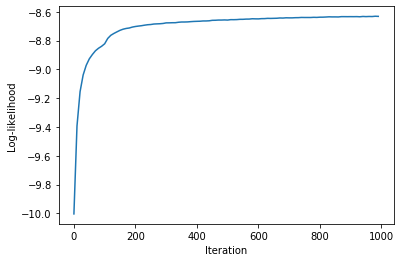

In [123]:
import matplotlib.pyplot as plt
plt.plot(time,LLs)
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')

In [124]:
model.summary()

<Basic Info>
| LDAModel (current version: 0.9.1)
| 20494 docs, 2047104 words
| Total Vocabs: 68689, Used Vocabs: 41921
| Entropy of words: -8.69615
| Removed Vocabs: use model result studi base
|
<Training Info>
| Iterations: 1000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.63168
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 30 (the number of topics between 1 ~ 32767)
| alpha: 0.1 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 413981393 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02115543 0.04057477 0.0473648  0.03881337 0.03060828 0.03408973
|   0.04750634 0.02920154 0.03210319 0.03348985 0.14166176 0.02239393
|   0.0205016

In [125]:
print('Saving...', file=sys.stderr, flush=True)
model.save(save_path, full=True) # If full is True, the model with its all documents and state will be saved. If you want to train more after, use full model. If False, only topic parameters of the model will be saved. This model can be only used for inference of an unseen document.

Saving...


Let's have a better look at the results!

In [126]:
for k in range(model.k):
    print('Topic #{}'.format(k))
    for word, prob in model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		survey	0.013973632827401161
		activ	0.012106232345104218
		data	0.011494496837258339
		particip	0.009594899602234364
		choic	0.009111951105296612
		time	0.008822182193398476
		person	0.007405532523989677
		household	0.007180156651884317
		behavior	0.007147959899157286
		estim	0.007147959899157286
Topic #1
		countri	0.01404231321066618
		polici	0.012152024544775486
		effect	0.011071859858930111
		firm	0.008573978208005428
		product	0.008523344993591309
		find	0.008287059143185616
		market	0.007881997153162956
		price	0.007240649312734604
		econom	0.006886220537126064
		increa	0.006126729305833578
Topic #2
		reaction	0.008497463539242744
		oxid	0.00690773269161582
		activ	0.006767048500478268
		water	0.005782259628176689
		surfac	0.0055853016674518585
		format	0.005543096456676722
		chemic	0.005332070402801037
		concentr	0.005303933285176754
		co	0.005135112442076206
		process	0.00483967550098896
Topic #3
		system	0.01928514428436756
		optim	0.016986647620797157
		energi	0.015

### Hyperparameter tuning by optimizing log-likelihood  
Note: log-likelihood is generally not considered a good measure for topic model performance...

In [134]:
def train_LDA(documents, k, min_cf=0, min_df=0, rm_top=0, alpha=0.1, eta=0.01, model_burn_in=100, 
              train_updates = 1000, train_iter = 10):
    
    # instantiate
    model = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k)
    
    # add documents to model
    for doc in documents: model.add_doc(doc)
    
    # training**
    model.burn_in = model_burn_in
    # initialising 
    model.train(iter=0)
    print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
    print('Removed top words:', model.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    # actual training 
    time = []
    LLs = []
    for i in range(0, train_updates, train_iter):
        model.train(train_iter)
        if i%100==0:print('Iteration: {}'.format(i))
        time.append(i)
        LLs.append(model.ll_per_word)
    
    return model, LLs, time

In [ ]:
# simple loop for minimizing perplexity on the training set

topics = [10,20,30]
perplexity_score = np.array([])
for k in topics:
    model, LLs, time = train_LDA(cleaned, k = k, train_updates = 600)
    perplexity_score = np.append(perplexity_score, model.perplexity)

topics[np.argmin(perplexity_score)]

In [168]:
# split data in train and test set

print(len(cleaned))
train_size = int(0.8*len(cleaned))

random.shuffle(cleaned)
train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:]

assert len(train_docs) + len(test_docs) == len(cleaned)

20494


In [171]:
def get_test_LL(test_docs, model):
    
    # make a list of documents of type required by tp
    test_set = []
    for doc in test_docs:
        test_set.append(model.make_doc(doc))
    
    # return topic distribution and log-likelihood of new documents
    topic_dist, likelihood = model.infer(test_set)
    
    # use mean log-likelihood as performance measure
    return np.mean(likelihood)

In [172]:
# loop for maximizing mean likelihood of test set

topics = [10,20,30]
log_likelihoods = np.array([])
for k in topics:
    model, LLs, time = train_LDA(train_docs, k = k, train_updates = 800)
    log_likelihoods = np.append(log_likelihoods, get_test_LL(test_docs, model))

topics[np.argmax(log_likelihoods)]

Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


30

In [173]:
print(likelihoods)

[-882.05810779 -882.89588814 -879.71187388]


In [138]:
# TODO: use new quality measures

## Next up

- experimenting with bigrams/trigrams
- more solid results on LDA (with other measures and grid-search) 
- experimenting with CTM
- experimenting with Pachinko